# Непараметрическое тестирование гипотез
Весь этот блок взять из DataCamp Statistical Thinking in Python : даже если вы его уже проходили, это почти ничего не значит) Пройдите еще разок

## Бутстрэппинг (bootstrapping) или голь на выдумки хитра. Как сделать много даных когда данных мало?

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams["figure.figsize"] = (4,3)
#пакет для красивой статистики
import seaborn as sns
import pandas as pd
import io
import requests

In [0]:
df_weather = pd.read_csv("https://github.com/AmoDinho/datacamp-python-data-science-track/raw/master/Statistical%20Thinking%20in%20Python%20(Part%202)/Datasets/sheffield_weather_station.csv",delim_whitespace=True, skiprows=8)
df_weather.head()

,yyyy,mm,tmax,tmin,af,rain,sun
0,1883,1,6.3,1.7,6,122.1,---
1,1883,2,8.0,2.8,2,69.8,---
2,1883,3,4.8,-1.6,23,29.6,---
3,1883,4,12.2,3.8,2,74.0,---
4,1883,5,14.7,6.2,0,31.2,---


In [0]:
#Функция для кумулятивной плотности
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Размер массива
    n=len(data) 
    # Отсортируем все точки в массиве
    x=np.sort(data)

    # y это просто доля точек в интервале от 1 до n
    y = np.arange(1, n+1) / n

    return x, y

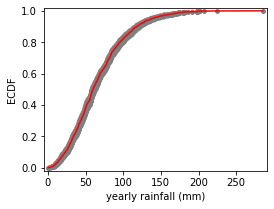

In [0]:
rainfall = df_weather['rain'].values
for i in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y,  linestyle='-', color = 'red')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

In [0]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

## Построим теперь всяких доверительных интервалов

0.9488593574676786
0.009426084544629714


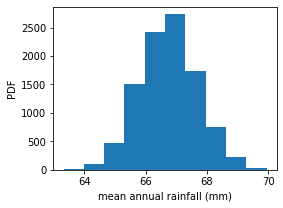

In [0]:
# Возмьмите 10000 реплик из rainfall и посчитайте среднее
bs_replicates = draw_bs_reps(rainfall, func = np.mean, size = 10000 )

# Для нормального распределения эмпирическая ошибка среднего значения вычисляется как стандартное std/sqrt(N). Вычислите ее для rainfall
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Вычислите ее с помощью бутсреп
bs_std = np.std(bs_replicates) / np.sqrt(len(bs_replicates))
print(bs_std)

# Нарисуйте гистограмку распределения среднего
_ = plt.hist(bs_replicates)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

## Доверительный интервал 
дает оценку для интервала в котором стоит ожидать какую-то конкретную величину при повторении эксперимента. 
Для некоторых распределений можно вычислить их аналитически (например для нормального), а в общем случае их всегда можно получить с помощью бустрапа
Для вычисления доверительного интервала нужно задать еще вероятность. Использовать процентили

In [0]:

print("95% значений средне-годовых осадков попадают в интервал: "+str(np.percentile(bs_replicates, 2.5))+','+ str(np.percentile(bs_replicates, 97.5)))

95% значений средне-годовых осадков попадают в интервал: 64.94219101123595,68.63620942571787


## Доверительные интервалы для любой статистики
Можно построить оценки для любой статистики, например для дисперсии

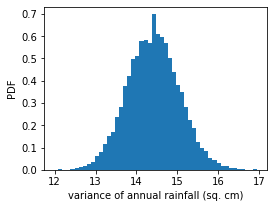

In [0]:
# Постройте 10000 реплик для оценки дисперсии
bs_replicates = draw_bs_reps(rainfall,np.var,10000)

bs_replicates = bs_replicates/100

# Make a histogram of the results
_ = plt.hist(bs_replicates, density =True, bins = 50)
_ = plt.xlabel('variance of annual rainfall (sq. cm)')
_ = plt.ylabel('PDF')

## Построение бутстреп доверительных интервалов для линейной регрессии

Можно даже построить доверительные интвервала для коэффициентов регрессии


In [0]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit( bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

## Задание: 
посмотрите задачку с линейной регрессией и постройте доверительные интервалы для среднего и дисперсии

>В ДатаКампе завершила курс, там строила эти графики для датасета по грамотности и плодовитости.

# Тестирование гипотез
Мы с вами уже определяли и оценивали параметры с учетом модели. Но остается вопрос: насколько вероятно получить изучаемые данные из выбранной модели? Этот вопрос решается с помощью тестирования гипотез. [Прочитайте про проверку гипотез и расскажите мне, что вы поняли, а лучше что не поняли!](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85_%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7)

### Вот помню было время и колбаса была вкуснее, и сметана гуще и девки краше

Давайте научимся сравнивать выборки между собой и делать выводы используя доказательную базу. ВАЖНО! Вопросы могут быть разные про выборки, поэтому и гипотезы формулируются по разному, и проверять их тоже нужно по разному. Вас может интересовать равенство двух распределений - это одна история, очень строгий вывод. Вас может интересовать задача сравнения двух средних, при этом распределения могут и отличаться. У вас могут быть разные исходные данные. Вариантов много, но принцип сравнения одинаковый. 

In [0]:
#Например давайте сравним распределения осадков в ноябре и июле. Но вообще из общих соображений наверное они должны быть разные. Проверим это!
#Для начала надо выделить июльские осадки и ноябрьские в отдельным переменные
rain_july = df_weather.loc[df_weather['mm']==7,'rain']
rain_november = df_weather.loc[df_weather['mm']==11,'rain']
rain_october = df_weather.loc[df_weather['mm']==10,'rain']

#### Тестирование гипотез с помощью перемешивания
Идея заключается в следующем  - соберем все данные в один массив, перемешаем его и нарежем на куски таких же размеров  как у исходных данных. Сделаем так много-много раз. Посчитаем характеристики перемешанных образцов  - и если мы их не можем отличить от исходных характеристик массивов, значит можно считать, что и наши эмпирические данные могут быть одним из таких вариантов перестановок. Если непонятно - ничего, сделайте задание, потом еще раз вернитесь. 

In [0]:
#Напишите функцию, которая берет на вход два массива, соединяет их, перемешивает и возвращает два массива с длинной как у исходных, 
#но состоящи из перемешанных элементов объединенного массива 
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Объедините два датасета с помощью функции  np.concatenate()
    data = np.concatenate((data1, data2))

    # Теперь перемешайте весь массив с помощью np.random.permutation()
    permuted_data = np.random.permutation(data)

    # Теперь переразбейте массив на два таких чтобы длина perm_sample_1 была равна длинне data1 , а perm_sample_2  - длинне data2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

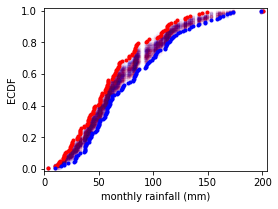

In [0]:
#А теперь давайте сгенерируем 50 таких перемешанных сетов и нарисуем получившиеся распределения для новых и исходных данных с помощью ecdf
def do_perm(data1, data2, size=50):
  """Permutes and displays 2 samples"""

  for i in range(50):
    # Сгенерируйте новые перемешанные датасеты с помощью написанной функции permutation_sample()
    perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)


    # Вычислите ecdf
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Нарисуйте ecdf
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

  # Вычислите ecdf из исходных данные
  x_1, y_1 = ecdf(data1)
  x_2, y_2 = ecdf(data2)
  _ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
  _ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

  # Добавим оси и красоты
  plt.margins(0.02)
  _ = plt.xlabel('monthly rainfall (mm)')
  _ = plt.ylabel('ECDF')
do_perm(rain_july, rain_november)

>Сравнили для июля и ноября: перемешанные данные не совпадают с реальными, а находятся между - значит показания действительно различаются.

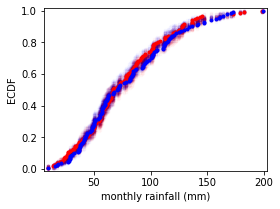

In [0]:
do_perm(rain_october, rain_november)

>Сравнили для октября и ноября: перемешивание дало понять, что разницы между данными для этих 2 месяцев нет.

In [0]:
frogs_path = "https://github.com/AmoDinho/datacamp-python-data-science-track/raw/master/Statistical%20Thinking%20in%20Python%20(Part%202)/Datasets/frog_tongue.csv"

df = pd.read_csv(frogs_path, usecols = ['ID','impact force (mN)' ],  skiprows=14)

Будем сравнивать группу взрослых (I и II категория) и юных особей (III и IV ). Сделайте новую колонку ID_2   в которой значению I и II  будет соответствовать A, а значениям III и  IV  - B.
Если забыли как это делать  - смотрите блокнот 2_Intro_to_Python_no_tasks 

In [0]:
df['ID_2']='A'
df.loc[np.logical_or(df['ID']=='III',df['ID']=='IV'), 'ID_2'] = 'B'
df.tail()

,ID,impact force (mN),ID_2
75,IV,402,B
76,IV,605,B
77,IV,711,B
78,IV,614,B
79,IV,468,B


 Не забываем про визуальный анализ. Используйте sns.swarmplot для того, чтобы посмотреть как в зависимости от категории 
 распределен параметр impact force (N). Не забудьте подписать оси. Нарисуйте два графика  - на одном  распределение параметра 
 по категориям ID, на втором ID_2. Напишите, что вы заметили?

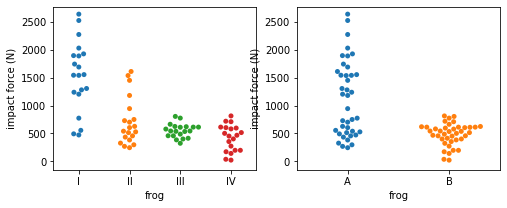

In [0]:
plt.figure(figsize = (8,3))
plt.subplot(121)
_ = sns.swarmplot(x='ID', y = 'impact force (mN)', data = df)

_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

plt.subplot(122)
_ = sns.swarmplot(x='ID_2', y = 'impact force (mN)', data = df)

_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

Кажется, что распределения отличаются. Но, вот посмотрите тут видно (и да так очень часто делают и не только студенты) - нам не подходит. Должна быть проведена проверка. Давайте сравним среднее у этих двух выборок

In [0]:
force_a = df.loc[df['ID_2']=='A','impact force (mN)'].values
force_b = df.loc[df['ID_2']=='B','impact force (mN)'].values
print(np.mean(force_a), np.mean(force_b))

1118.775 484.6


### Сравнение двух средних. 
***Нулевая гипотеза***: 
разницы между средними нет: mean_1 - mean_2 = 0

***Альтернативная гипотеза***:
mean_1 > mean_2 (кто кого должен быть больше понимайте из реальных данных)

***Pipeline*** для проверки гипотезы:
 - Формулируем гипотезу, с помощью которой можно оценить адекватность получить имеющиеся данные 
 - Нам нужна какая-то тестовая статистика - то есть !ОДНО! число, которое мы можем оценить и из исходных данных и из симуляций. Она должна дать базис для сравнения двух гипотез
 - Считаем p-value для этой статистики. P-value  - это вероятность получения такого же или большего значения вашей тестовой статистики как в наблюдаемых данных, при условии что нулевая гипотеза верна. !!! НЕ вероятность того, что нулевая гипотеза верна

In [0]:
#Сейчас решаем задачу двух средних для случая когда у нас на руках есть две довольно большие выборки, 
#среднее между которыми мы хотим сравнить между собой. Делать это будем с помощью уже довольно знакомой процедуры перемешивания.

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Инициализируем пустой массив размера size
    perm_replicates = np.empty(size)

    #Делаем перемешанные образцы в количестве size 
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Вычислаяем тестовую статистику на основе этих двух образцов
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [0]:
#Вариант тестовой статистики для разницы между средними
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # Разница между средними data_1, data_2
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Вычислите разницу для эксперимента с лягушками между force_a и force_b empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Получите 10000 реплик для разницы среднего с помощью перемешивания: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Вычислите p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Выведите p value. Какой вывод делаем? Прямо напишите его и аргументируйте в ячейке.
print('p-value =', p)

p-value = 0.0


P-value равно 0, а значит вероятность встретить такую же выборку при верности нашей гипотезы тоже равна нулю - гипотезу спокойно отвергаем.

In [0]:
#Сделайте теперь эксперимент: повыкидывайте большие значения (больше 1200) из группы взрослых лягушек и маленькие(меньше 300) и снова проведите тест на равенство средних  
force_a = df.loc[np.logical_and(df['ID_2']=='A',df['impact force (mN)']<1200),'impact force (mN)'].values
force_b = df.loc[np.logical_and(df['ID_2']=='B',df['impact force (mN)']>100),'impact force (mN)'].values
print(np.mean(force_a), np.mean(force_b))

563.8095238095239 508.55263157894734


In [0]:
# Вычислите разницу для эксперимента с лягушками между force_a и force_b empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Получите 10000 реплик для разницы среднего с помощью перемешивания: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Вычислите p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Выведите p value. Какой вывод делаем? Прямо напишите его и аргументируйте в ячейке.
print('p-value =', p)

p-value = 0.1457


Пи-вэлью стал примерно 15%. Уже видим, что такая выборка (средние силы удара), как в реальных данных (ограниченных нами), может встретиться с небольшой вероятностью, если опять же наша гипотеза верна.

In [0]:
#Сравните теперь между собой группы взрослых лягушек и детей (группы I и II, III и IV)
force_a = df.loc[np.logical_and(df['ID']=='III', df['impact force (mN)']<600),'impact force (mN)'].values
force_b = df.loc[np.logical_and(df['ID']=='IV',df['impact force (mN)']>300),'impact force (mN)'].values
print(np.mean(force_a), np.mean(force_b))

472.4166666666667 564.6153846153846


In [0]:
# Вычислите разницу для эксперимента с лягушками между force_a и force_b empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Получите 10000 реплик для разницы среднего с помощью перемешивания: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Вычислите p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Выведите p value. Какой вывод делаем? Прямо напишите его и аргументируйте в ячейке.
print('p-value =', p)

p-value = 0.9785


Очевидно, что, если сравнивать между собой две группы детей, мы не увидим большой разницы между их силами удара. В почти 98% случаев мы повторим тестовые данные, если нулевая гипотеза о равенстве силы удара верна.

In [0]:
#Сравните теперь между собой группы взрослых лягушек и детей (группы I и II, III и IV)
force_a = df.loc[np.logical_and(df['ID']=='II', df['impact force (mN)']<1200),'impact force (mN)'].values
force_b = df.loc[np.logical_and(df['ID']=='I',df['impact force (mN)']>1200),'impact force (mN)'].values
print(np.mean(force_a), np.mean(force_b))

561.3529411764706 1769.1875


In [0]:
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

empirical_diff_means = diff_of_means(force_a, force_b)
# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 1.0


Видим, что и у взрослых разницы между средними нет.

## Перемешивание vs bootstrap
Перемешивание и бутстрап. Почитайте книжечку из папочки и расскажите мне кто зачем нужен

>1. Перемешивание требует, чтобы наши данные имели одинаковую дисперсию и размер выборки (иначе результат будет недостоверным). С его помощью можно сравнить распределение двух популяций, но мы никогда не получим больше информации, чем уже есть.
2. Бутстрэп искусственно создаёт новые сэмплы из выборки. Можно нагенерить дополнительных данных, чтобы посмотреть на дисперсию и предположить, при каком кол-ве экспериментов (сэмплов) можно было бы с определённой уверенностью попасть в 5% по нашей статистике и отвергнуть нулевую гипотезу.

In [0]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """bootstrap replicates."""

    # Инициализируйте пустой массив размером size
    bs_replicates = np.empty(size)

    # Посчитайте характеристику реплики:
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [0]:
force_3 = df.loc[np.logical_and(df['ID']=='III', df['impact force (mN)']<1000),'impact force (mN)'].as_matrix()
force_4 = df.loc[np.logical_and(df['ID']=='IV',df['impact force (mN)']>100),'impact force (mN)'].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
# Make an array of translated impact forces: translated_force_b
translated_force_3 = force_3  - np.mean(force_3)+560.1

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_3, func = np.mean, size = 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_3)) / 10000

# Print the p-value
print('p = ', p)

p =  0.3649


In [0]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a,force_b)

# Concatenate forces: forces_concat
forces_concat = np.concatenate((force_a, force_b))

# Initialize bootstrap replicates: bs_replicates
bs_replicates = np.empty(10000)

for i in range(10000):
    # Generate bootstrap sample
    bs_sample = np.random.choice(forces_concat, size = len(forces_concat))
    
    # Compute replicate
    bs_replicates[i] = diff_of_means(bs_sample[:len(force_a)],
                                     bs_sample[len(force_a):])

# Compute and print p-value: p
p = np.sum(bs_replicates>=empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 1.0


In [0]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates>=empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.9857
